# Application of Convolutional Neural Network on Cancer Detection

With the development of technology, computer vision becomes more widely applied in the area of disease diagnosis and medical science. This study focused on detecting cancerous tumors with the application of convolutional neural network (CNN). A total number of 220,025 pathology images are fed to CNN for training purpose and another 57,458 images are predicted for measuring model performance. Each pathology image has 96X96 pixels and the cancerous tumor only possibly appear in the center 32X32 pixels region. An additional csv file that contains image id and ground truth labels is utilized as an indicator of the existence of tumor issue.

### Citation

[1] B. S. Veeling, J. Linmans, J. Winkens, T. Cohen, M. Welling. "Rotation Equivariant CNNs for Digital Pathology". arXiv:1806.03962

[2] Ehteshami Bejnordi et al. Diagnostic Assessment of Deep Learning Algorithms for Detection of Lymph Node Metastases in Women With Breast Cancer. JAMA: The Journal of the American Medical Association, 318(22), 2199–2210. doi:jama.2017.14585

Will Cukierski. (2018). Histopathologic Cancer Detection. Kaggle. https://kaggle.com/competitions/histopathologic-cancer-detection

## Import Library

In [33]:
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
import cv2
import tensorflow as tf
import keras

from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization

#!pip install keras-tuner
import keras_tuner

#!pip install image-similarity-measures
import image_similarity_measures
from image_similarity_measures.quality_metrics import rmse, ssim, fsim

## Setting Up Colab Environment

GPU provided with Google Colab will be utilized for training CNN. To reduce running time, zip files are moved to Colab local environment and unzipped in designated folders. Training labels csv file is moved under the same root folder as well.

In [2]:
from google.colab import drive

In [3]:
# mount google drive locally
drive.mount('/gdrive', force_remount = True)

Mounted at /gdrive


In [4]:
train_zip_path = '/gdrive/MyDrive/week3_project/data/train.zip'
test_zip_path = '/gdrive/MyDrive/week3_project/data/test.zip'
training_label_path = '/gdrive/MyDrive/week3_project/data/train_labels.csv'
local_path = '/content'

In [5]:
# copy file from google drive to colab
!cp '{train_zip_path}' .
!cp '{test_zip_path}' .
!cp '{training_label_path}' .

In [6]:
# unzip training and test images zip file
os.chdir(local_path)
!unzip -q 'train.zip' -d '/content/training_data/'
!unzip -q 'test.zip' -d '/content/test_data/'

## Exploratory Data Analysis

In [7]:
training_labels = pd.read_csv(os.path.join(local_path, 'train_labels.csv'))
training_labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [8]:
training_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


Training labels csv file has 220,025 IDs associated with their ground truth labels and both columns doesn't contain any null values. According to the data decription of the Kaggle competition, duplicate images are removed and thus, ids are expected to be unique in this file.

Notice that ids are all missing the image file extension 'tif' and labels have integer data types. A new column named image name will be created and defined as the concatenation of id and 'tif'. This column will be later used for extracting images from training_data and testing_data folders. Additionally, labels will be converted to strings.

In [9]:
training_labels_c = training_labels.copy()
training_labels_c['image_name'] = training_labels_c['id'] + '.tif'
training_labels_c['label'] = training_labels_c['label'].astype(str)
training_labels_c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   id          220025 non-null  object
 1   label       220025 non-null  object
 2   image_name  220025 non-null  object
dtypes: object(3)
memory usage: 5.0+ MB


In [10]:
training_labels_c.head()

,id,label,image_name
0,f38a6374c348f90b587e046aac6079959adf3835,0,f38a6374c348f90b587e046aac6079959adf3835.tif
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif
2,755db6279dae599ebb4d39a9123cce439965282d,0,755db6279dae599ebb4d39a9123cce439965282d.tif
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif
4,068aba587a4950175d04c680d38943fd488d6a9d,0,068aba587a4950175d04c680d38943fd488d6a9d.tif


<Axes: >

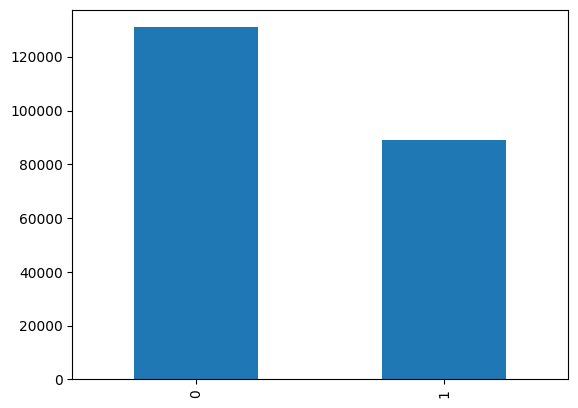

In [11]:
# Check label distribution
training_labels_c['label'].value_counts(sort = False).plot.bar()

Above bar plot illustrates that the target class distribution is slightly imbalanced. It's quite common for medical data to have class imbalanced problem. In this study, a technique named image augmentation will be applied for artificially expanding the dataset to handle this issue.

In this next step, three images belonging to each class will be displayed to gain a deeper understanding on the visual difference between cancerous tumor and normal cells.

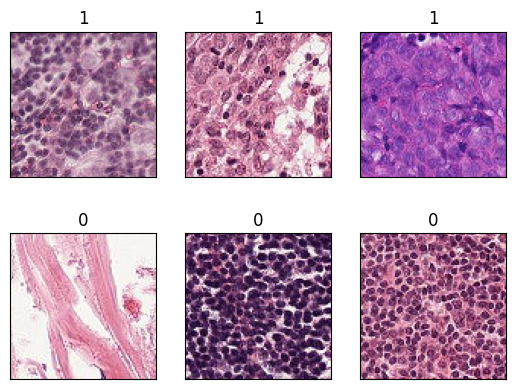

In [22]:
sample_t = training_labels_c[training_labels_c['label'] == '1'].sample(n = 3, random_state = 42)
sample_h = training_labels_c[training_labels_c['label'] == '0'].sample(n = 3, random_state = 42)
f, ax = plt.subplots(2,3)
for i in range(sample_t.shape[0]):
    img = cv2.imread(os.path.join(local_path, 'training_data', sample_t.iloc[i, 2]))
    ax[0,i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax[0,i].title.set_text(str(sample_t.iloc[0,1]))
    ax[0,i].set_xticks([])
    ax[0,i].set_yticks([])

for i in range(sample_h.shape[0]):
    img = cv2.imread(os.path.join(local_path, 'training_data',  sample_h.iloc[i, 2]))
    ax[1,i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax[1,i].title.set_text(str(sample_h.iloc[0,1]))
    ax[1,i].set_xticks([])
    ax[1,i].set_yticks([])

Above six plots are plotted for a side-by-side comparison on cancerous tumor and normal cells. Images in each pair seem to have different color but there isn't any clear pattern of visual differences. Or at least the differences are unable to be distinguished by human eyes.

In [32]:
# compute image similarity
img_similarity_df = pd.DataFrame(columns = ['rmse', 'ssim', 'fsim'])
for i in range(sample_t.shape[0]):
    img1 = cv2.imread(os.path.join(local_path, 'training_data', sample_t.iloc[i, 2]))
    img2 = cv2.imread(os.path.join(local_path, 'training_data', sample_h.iloc[i, 2]))
    img_similarity_df.loc[i] = [rmse(img1, img2), ssim(img1, img2), fsim(img1, img2)]

img_similarity_df

,rmse,ssim,fsim
0,0.020876,0.825101,0.385308
1,0.026029,0.633693,0.484275
2,0.016068,0.801311,0.445398


Above summary chart shows the value of three image similarity matrices by comparing three pairs of tumor and normal cell images. Low RMSE of all three pairs means images in each pair are very different pixel by pixel. The high SSIM and low FSIM shows that images of cancerous tumor and normal cells are perceptual similar but dissimilar on structures and image features. FSIM could be a good loss function for CNN to learn distinguishing tumor and normal cells.

In [ ]:
# check image resolution
cv2.imread(os.path.join(local_path, 'training_data', sample_t.iloc[1, 2])).shape

(96, 96, 3)

Each image has 96X96 pixels and three channels. By scaling them down to 1X1 squared images before feeding to the neural network, a higher computational efficiency can be achieved.

## Data Preprocessing

In this section, image data is preprocessed and split into training and validation set in the ratio of 8:2. Image augmentation is a technique to randomly generate images based on the training set to handle class imbalance problem, avoid overfitting and make the model generalize better. In this project, random images are generated by shifting the training images vertically and horizontally as well as distorting the training images. In addition, both training and validation images are also normalized by scaling down to 1X1 pixcel.

In [ ]:
# data preprocessing

train_datagen = image.ImageDataGenerator(
    rescale = 1./255,
    width_shift_range = 0.3,
    height_shift_range = 0.3,
    shear_range = 0.3,
    validation_split = 0.2
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe = training_labels_c,
    directory = os.path.join(local_path, 'training_data'),
    x_col = 'image_name',
    y_col = 'label',
    target_size = (96, 96),
    class_mode = 'binary',
    batch_size = 32,
    shuffle = False,
    seed = 42,
    subset = 'training'
)

val_datagen = image.ImageDataGenerator(
    rescale = 1./255,
    validation_split = 0.2
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe = training_labels_c,
    directory = os.path.join(local_path, 'training_data'),
    x_col = 'image_name',
    y_col = 'label',
    class_mode = 'binary',
    target_size = (96, 96),
    batch_size = 32,
    shuffle = False,
    seed = 42,
    subset = 'validation'
)


Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


In [ ]:
val_generator[0][0].shape

(32, 96, 96, 3)

Images are now preprocessed and split into training and validation set. Each batch has the expected shapes.

## CNN Model Training and Analysis

According to the exploratory data analysis, the first CNN model is designed as following:

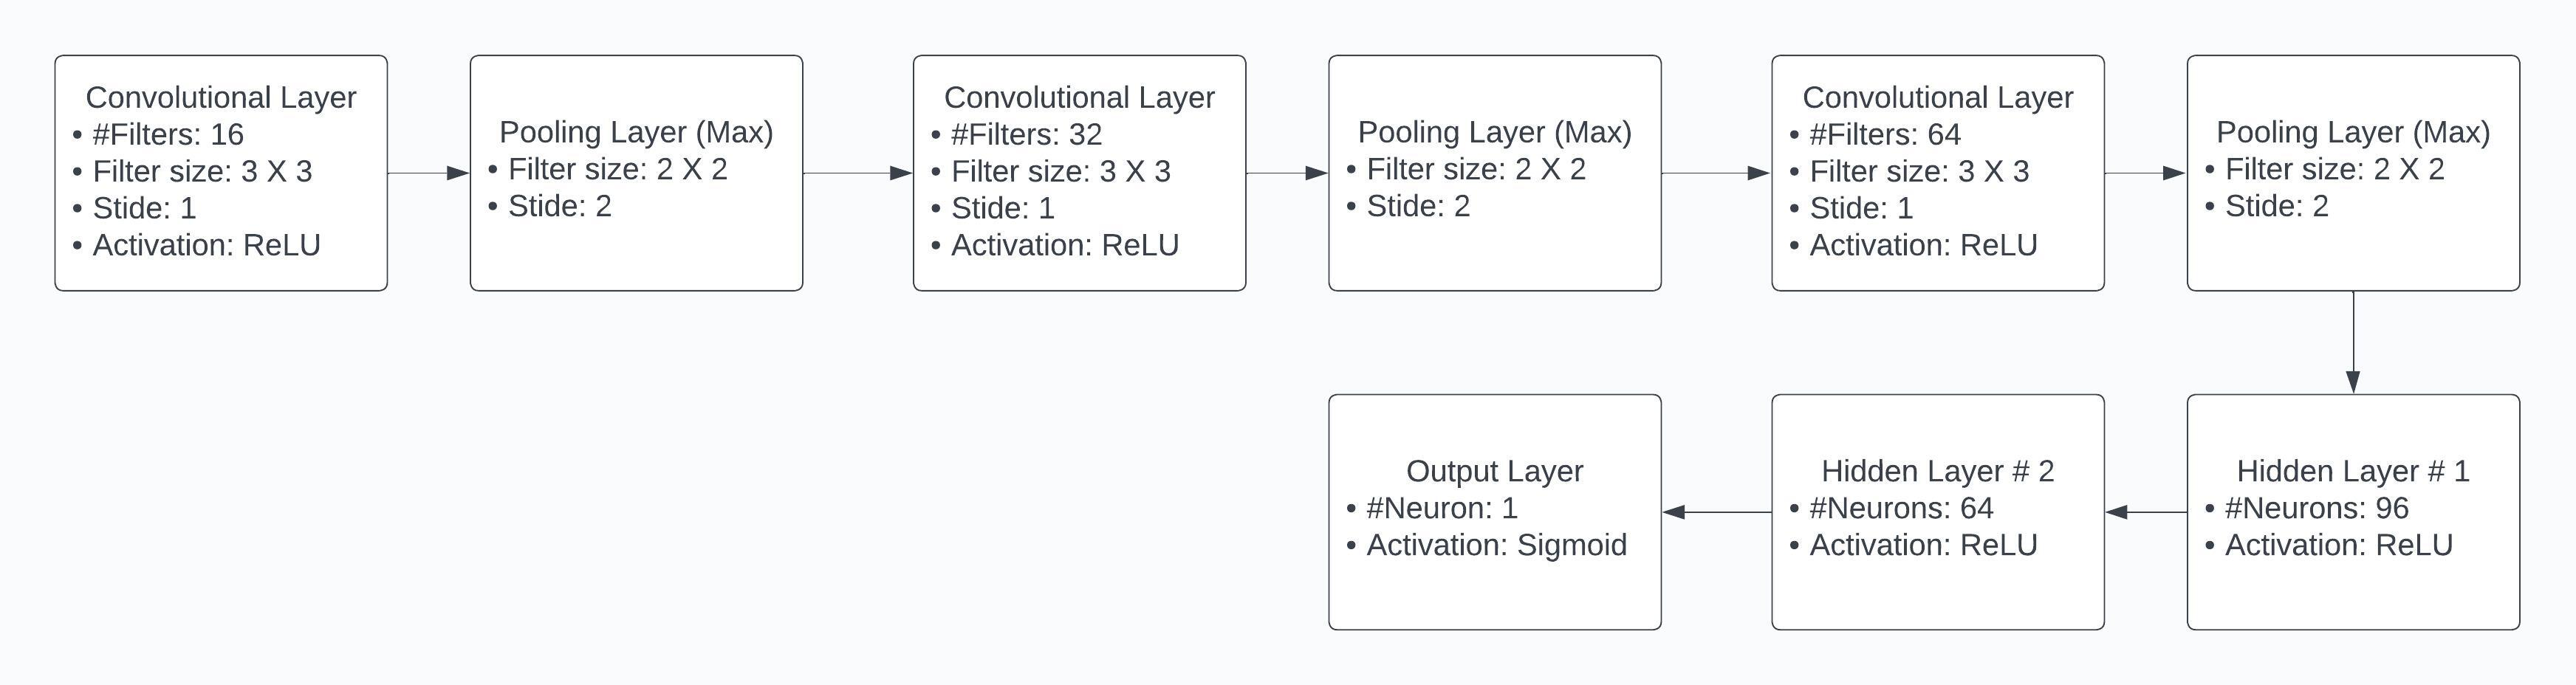

Filter sizes are selected to be 3 by 3 and strides are chosen as 1 for all convolutional layers. They are common choices, and a stack of small filter convolutional layer is more preferable to one large receptive field convolution layer since it allows CNN to express more powerful features with a smaller number of parameters. Number of filters are selected to be 16 in the first convolutional layer and doubled in each subsequent layer. The idea is to start with a simple model and update it through a performance-based iterative process. Considering the outer region doesn't include cancerous tumor, paddings are set to be 0. Rectified linear unit (ReLU) is used as the activation function for input and hidden layers. Besides, a maximum pooling layer is inserted in between successive convolutional layers, with a 2X2 filters and a stride of 2 to downsample the volume of input spatially. Further, a flatten layer is introduced after the last [Conv, Pooling] layers to convert the output to an 1d array to prepare the input data that'll be fed to fully connected layers. Two fully connected layers with relatively few neurons are inserted after the flatten layer. Sigmoid function is used as the activation function in the output layer since our CNN is built for studying a binary classification problem.



In [ ]:
model_base = Sequential()
model_base.add(Conv2D(16, (3,3), 1, activation = 'relu', input_shape = (96, 96, 3)))
model_base.add(MaxPooling2D(2, 2))

model_base.add(Conv2D(32, (3,3), 1, activation = 'relu'))
model_base.add(MaxPooling2D(2, 2))

model_base.add(Conv2D(64, (3,3), 1, activation = 'relu'))
model_base.add(MaxPooling2D(2, 2))

model_base.add(Flatten())

model_base.add(Dense(96, activation = 'relu'))
model_base.add(Dense(64, activation = 'relu'))
model_base.add(Dense(1, activation = 'sigmoid'))

model_base.compile('adam', loss = tf.losses.BinaryCrossentropy(), metrics = ['accuracy', tf.keras.metrics.AUC()])
model_base.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 47, 47, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 45, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 22, 22, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 10, 10, 64)        0

In [ ]:
hist = model_base.fit(train_generator, epochs = 5, validation_data = val_generator)

Epoch 1/5
5501/5501 [==============================] - 528s 95ms/step - loss: 0.4323 - accuracy: 0.8035 - auc: 0.8747 - val_loss: 0.3349 - val_accuracy: 0.8568 - val_auc: 0.9272
Epoch 2/5
5501/5501 [==============================] - 512s 93ms/step - loss: 0.3500 - accuracy: 0.8485 - auc: 0.9196 - val_loss: 0.3092 - val_accuracy: 0.8708 - val_auc: 0.9399
Epoch 3/5
5501/5501 [==============================] - 514s 93ms/step - loss: 0.3245 - accuracy: 0.8613 - auc: 0.9310 - val_loss: 0.3478 - val_accuracy: 0.8514 - val_auc: 0.9413
Epoch 4/5
5501/5501 [==============================] - 527s 96ms/step - loss: 0.3113 - accuracy: 0.8683 - auc: 0.9364 - val_loss: 0.3169 - val_accuracy: 0.8737 - val_auc: 0.9434
Epoch 5/5
5501/5501 [==============================] - 509s 93ms/step - loss: 0.3008 - accuracy: 0.8740 - auc: 0.9406 - val_loss: 0.2901 - val_accuracy: 0.8822 - val_auc: 0.9476


Text(0.5, 1.0, 'AUC')

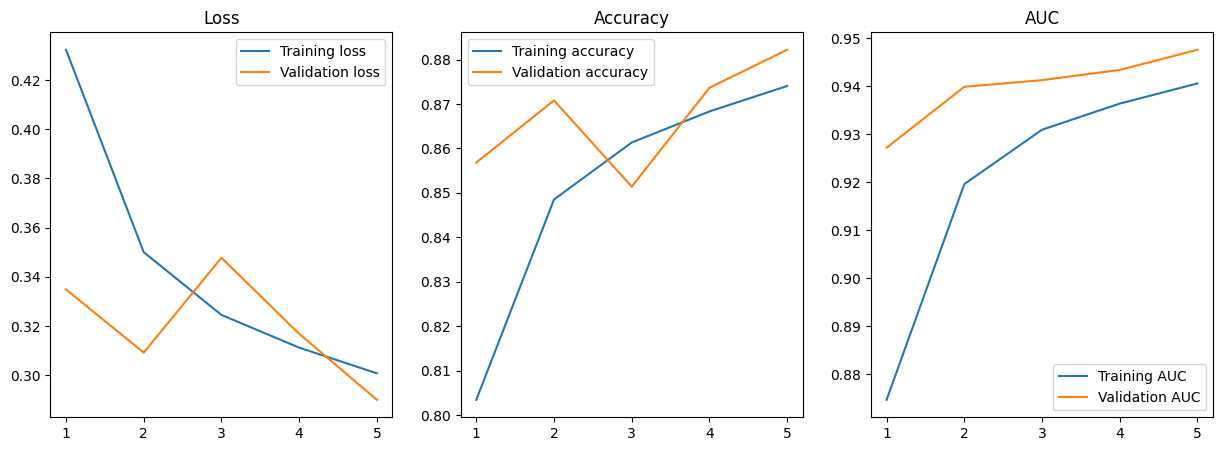

In [ ]:
f, ax = plt.subplots(1, 3, figsize = (15, 5))
ax[0].plot(range(1, 6), hist.history['loss'], label = 'Training loss')
ax[0].plot(range(1, 6),hist.history['val_loss'], label = 'Validation loss')
ax[0].legend()
ax[0].set_title('Loss')
ax[1].plot(range(1, 6),hist.history['accuracy'], label = 'Training accuracy')
ax[1].plot(range(1, 6),hist.history['val_accuracy'], label = 'Validation accuracy')
ax[1].legend()
ax[1].set_title('Accuracy')
ax[2].plot(range(1, 6),hist.history['auc'], label = 'Training AUC')
ax[2].plot(range(1, 6),hist.history['val_auc'], label = 'Validation AUC')
ax[2].legend()
ax[2].set_title('AUC')

Our CNN model has fairly good accuracy and AUC score at the last epoch. It's also noticeable that training loss is higher than validation loss at all epochs except the third and fourth one, which indicates the presence of underfitting. One possible reason is that training loss is measured around half an epoch earlier than validation loss. Indeed, training loss will be closer to the validation loss if it's shifted by half an epoch to the left. Another potential cause is that the training set is more challenging than validation set. Additionally, validation loss became smaller than the training loss at the last epoch and it would be beneficial to learn their future trend. To resolve above issue, the model will be updated by introducing a batch normalization layer after each convolutional layer. Batch normalization layers are expected to stabilize the training process and reduce both underfitting and overfitting. Filter size of the second convolution layer will be increased to 5X5, which allows CNN to extract more information about the spatial structure of input images. A larger filter size also reduces overfitting. Lastly, CNN will learn the training images deeper by increasing total number of epochs to 10.

In [ ]:
model2 = Sequential()
model2.add(Conv2D(16, (3,3), 1, activation = 'relu', input_shape = (96, 96, 3)))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(2, 2))

model2.add(Conv2D(32, (5,5), 1, activation = 'relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(2, 2))

model2.add(Conv2D(64, (3,3), 1, activation = 'relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(2, 2))

model2.add(Flatten())

model2.add(Dense(96, activation = 'relu'))
model2.add(Dense(64, activation = 'relu'))
model2.add(Dense(1, activation = 'sigmoid'))

model2.compile('adam', loss = tf.losses.BinaryCrossentropy(), metrics = ['accuracy', tf.keras.metrics.AUC()])
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 16)        448       
                                                                 
 batch_normalization (Batch  (None, 94, 94, 16)        64        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 47, 47, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 43, 43, 32)        12832     
                                                                 
 batch_normalization_1 (Bat  (None, 43, 43, 32)        128       
 chNormalization)                                                
                                                        

In [ ]:
hist2 = model2.fit(train_generator, epochs = 10, validation_data = val_generator)

Epoch 1/10
5501/5501 [==============================] - 538s 96ms/step - loss: 0.3953 - accuracy: 0.8272 - auc: 0.8970 - val_loss: 0.5281 - val_accuracy: 0.7937 - val_auc: 0.9127
Epoch 2/10
5501/5501 [==============================] - 541s 98ms/step - loss: 0.3230 - accuracy: 0.8641 - auc: 0.9317 - val_loss: 0.5886 - val_accuracy: 0.7850 - val_auc: 0.8996
Epoch 3/10
5501/5501 [==============================] - 522s 95ms/step - loss: 0.2901 - accuracy: 0.8811 - auc: 0.9445 - val_loss: 0.5277 - val_accuracy: 0.7770 - val_auc: 0.8728
Epoch 4/10
5501/5501 [==============================] - 537s 98ms/step - loss: 0.2695 - accuracy: 0.8905 - auc: 0.9521 - val_loss: 0.4739 - val_accuracy: 0.8094 - val_auc: 0.9399
Epoch 5/10
5501/5501 [==============================] - 525s 95ms/step - loss: 0.2567 - accuracy: 0.8963 - auc: 0.9565 - val_loss: 0.8769 - val_accuracy: 0.7481 - val_auc: 0.8107
Epoch 6/10
5501/5501 [==============================] - 521s 95ms/step - loss: 0.2471 - accuracy: 0.9011 

Text(0.5, 1.0, 'AUC')

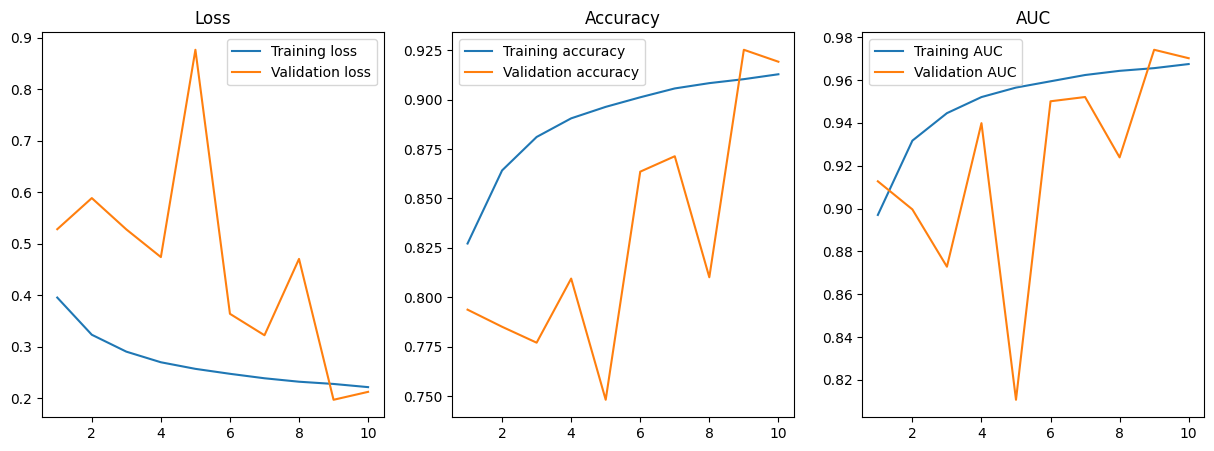

In [ ]:
f, ax = plt.subplots(1, 3, figsize = (15, 5))
ax[0].plot(range(1, 11), hist2.history['loss'], label = 'Training loss')
ax[0].plot(range(1, 11),hist2.history['val_loss'], label = 'Validation loss')
ax[0].legend()
ax[0].set_title('Loss')
ax[1].plot(range(1, 11),hist2.history['accuracy'], label = 'Training accuracy')
ax[1].plot(range(1, 11),hist2.history['val_accuracy'], label = 'Validation accuracy')
ax[1].legend()
ax[1].set_title('Accuracy')
ax[2].plot(range(1, 11),hist2.history['auc'], label = 'Training AUC')
ax[2].plot(range(1, 11),hist2.history['val_auc'], label = 'Validation AUC')
ax[2].legend()
ax[2].set_title('AUC')

The new CNN has a higher accuracy and AUC score than the previous one. The better performance most likely resulted from the larger filter size since it allows CNN to extract more information of the input data. Besides, batch normalization stabilizes the training process by reducing the internal covariate shift and improves the neural network on the aspect of underfitting. Validation loss fluctuates around the training loss at the last two epochs, which might be a sign of underfitting. Learning rate will be tunned to handle this issue.

In [ ]:
model3 = Sequential()
model3.add(Conv2D(16, (3,3), 1, activation = 'relu', input_shape = (96, 96, 3)))
model3.add(BatchNormalization())
model3.add(MaxPooling2D(2, 2))

model3.add(Conv2D(32, (5,5), 1, activation = 'relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D(2, 2))

model3.add(Conv2D(64, (3,3), 1, activation = 'relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D(2, 2))

model3.add(Flatten())

model3.add(Dense(96, activation = 'relu'))
model3.add(Dense(64, activation = 'relu'))
model3.add(Dense(1, activation = 'sigmoid'))

adam_opt = tf.keras.optimizers.Adam(learning_rate = 0.0005)

model3.compile(adam_opt, loss = tf.losses.BinaryCrossentropy(), metrics = ['accuracy', tf.keras.metrics.AUC()])
model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 16)        448       
                                                                 
 batch_normalization (Batch  (None, 94, 94, 16)        64        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 47, 47, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 43, 43, 32)        12832     
                                                                 
 batch_normalization_1 (Bat  (None, 43, 43, 32)        128       
 chNormalization)                                                
                                                        

In [ ]:
hist3 = model3.fit(train_generator, epochs = 10, validation_data = val_generator)

Epoch 1/10
5501/5501 [==============================] - 522s 94ms/step - loss: 0.3980 - accuracy: 0.8269 - auc: 0.8950 - val_loss: 0.8269 - val_accuracy: 0.6798 - val_auc: 0.8293
Epoch 2/10
5501/5501 [==============================] - 513s 93ms/step - loss: 0.3285 - accuracy: 0.8619 - auc: 0.9289 - val_loss: 0.4833 - val_accuracy: 0.8197 - val_auc: 0.8802
Epoch 3/10
5501/5501 [==============================] - 512s 93ms/step - loss: 0.2943 - accuracy: 0.8791 - auc: 0.9429 - val_loss: 0.3436 - val_accuracy: 0.8556 - val_auc: 0.9272
Epoch 4/10
5501/5501 [==============================] - 518s 94ms/step - loss: 0.2742 - accuracy: 0.8880 - auc: 0.9501 - val_loss: 0.2601 - val_accuracy: 0.8939 - val_auc: 0.9573
Epoch 5/10
5501/5501 [==============================] - 504s 92ms/step - loss: 0.2586 - accuracy: 0.8962 - auc: 0.9555 - val_loss: 0.4234 - val_accuracy: 0.8349 - val_auc: 0.9225
Epoch 6/10
5501/5501 [==============================] - 504s 92ms/step - loss: 0.2490 - accuracy: 0.8995 

Text(0.5, 1.0, 'AUC')

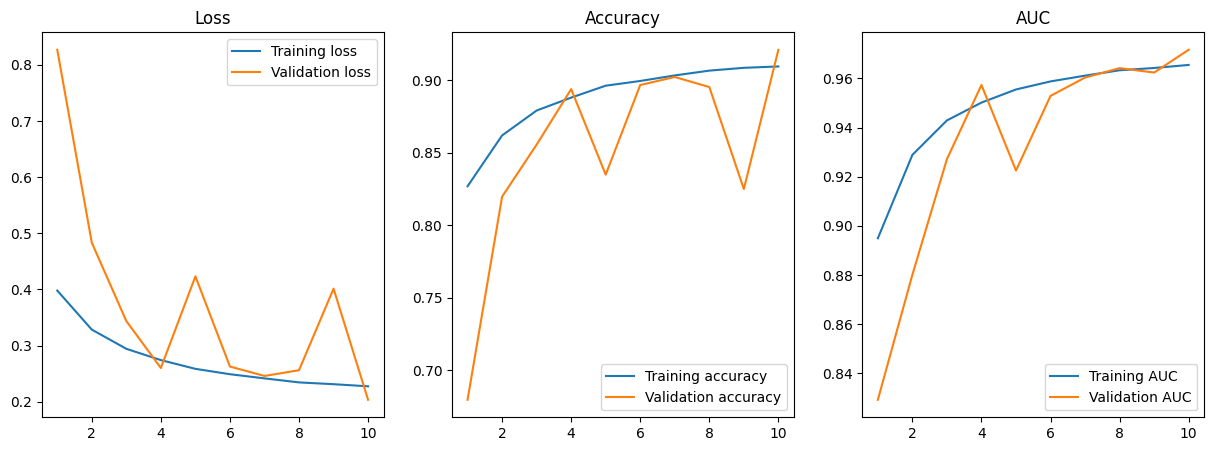

In [ ]:
f, ax = plt.subplots(1, 3, figsize = (15, 5))
ax[0].plot(range(1, 11), hist3.history['loss'], label = 'Training loss')
ax[0].plot(range(1, 11),hist3.history['val_loss'], label = 'Validation loss')
ax[0].legend()
ax[0].set_title('Loss')
ax[1].plot(range(1, 11),hist3.history['accuracy'], label = 'Training accuracy')
ax[1].plot(range(1, 11),hist3.history['val_accuracy'], label = 'Validation accuracy')
ax[1].legend()
ax[1].set_title('Accuracy')
ax[2].plot(range(1, 11),hist3.history['auc'], label = 'Training AUC')
ax[2].plot(range(1, 11),hist3.history['val_auc'], label = 'Validation AUC')
ax[2].legend()
ax[2].set_title('AUC')

The new CNN performs better than the previous one with regard to all three metrics - loss, accuracy and AUC score. Validation loss has a sharp increase at the second epoch and approaches training loss quickly during the training process. Similar happened to validation AUC score and it ends with fluctuating around training AUC. However, the model still underfits at some epochs. Next, image augmentation will be removed along with the insertion of dropout layers after each pooling layer to study their effect.

In [ ]:
model4 = Sequential()
model4.add(Conv2D(16, (3,3), 1, activation = 'relu', input_shape = (96, 96, 3)))
model4.add(BatchNormalization())
model4.add(MaxPooling2D(2, 2))
model4.add(Dropout(0.2))

model4.add(Conv2D(32, (5,5), 1, activation = 'relu'))
model4.add(BatchNormalization())
model4.add(MaxPooling2D(2, 2))
model4.add(Dropout(0.2))

model4.add(Conv2D(64, (3,3), 1, activation = 'relu'))
model4.add(BatchNormalization())
model4.add(MaxPooling2D(2, 2))
model4.add(Dropout(0.2))

model4.add(Flatten())

model4.add(Dense(96, activation = 'relu'))
model4.add(Dense(64, activation = 'relu'))
model4.add(Dense(1, activation = 'sigmoid'))

adam_opt = tf.keras.optimizers.Adam(learning_rate = 0.0005)

model4.compile(adam_opt, loss = tf.losses.BinaryCrossentropy(), metrics = ['accuracy', tf.keras.metrics.AUC()])
model4.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 94, 94, 16)        448       
                                                                 
 batch_normalization_3 (Bat  (None, 94, 94, 16)        64        
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 47, 47, 16)        0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 47, 47, 16)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 43, 43, 32)        12832     
                                                                 
 batch_normalization_4 (Bat  (None, 43, 43, 32)       

In [12]:
datagen2 = image.ImageDataGenerator(
    rescale = 1./255,
    validation_split = 0.2
)

train_generator2 = datagen2.flow_from_dataframe(
    dataframe = training_labels_c,
    directory = os.path.join(local_path, 'training_data'),
    x_col = 'image_name',
    y_col = 'label',
    target_size = (96, 96),
    class_mode = 'binary',
    batch_size = 32,
    shuffle = False,
    seed = 42,
    subset = 'training'
)

val_generator2 = datagen2.flow_from_dataframe(
    dataframe = training_labels_c,
    directory = os.path.join(local_path, 'training_data'),
    x_col = 'image_name',
    y_col = 'label',
    class_mode = 'binary',
    target_size = (96, 96),
    batch_size = 32,
    shuffle = False,
    seed = 42,
    subset = 'validation'
)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


In [ ]:
hist4 = model4.fit(train_generator2, epochs = 10, validation_data = val_generator2)

Epoch 1/10
5501/5501 [==============================] - 158s 29ms/step - loss: 0.3478 - accuracy: 0.8506 - auc_1: 0.9211 - val_loss: 0.3517 - val_accuracy: 0.8509 - val_auc_1: 0.9236
Epoch 2/10
5501/5501 [==============================] - 165s 30ms/step - loss: 0.2908 - accuracy: 0.8792 - auc_1: 0.9451 - val_loss: 0.3090 - val_accuracy: 0.8775 - val_auc_1: 0.9431
Epoch 3/10
5501/5501 [==============================] - 154s 28ms/step - loss: 0.2583 - accuracy: 0.8948 - auc_1: 0.9565 - val_loss: 0.5003 - val_accuracy: 0.8230 - val_auc_1: 0.8993
Epoch 4/10
5501/5501 [==============================] - 161s 29ms/step - loss: 0.2356 - accuracy: 0.9044 - auc_1: 0.9637 - val_loss: 0.5428 - val_accuracy: 0.8149 - val_auc_1: 0.8908
Epoch 5/10
5501/5501 [==============================] - 160s 29ms/step - loss: 0.2186 - accuracy: 0.9120 - auc_1: 0.9685 - val_loss: 0.2700 - val_accuracy: 0.8938 - val_auc_1: 0.9594
Epoch 6/10
5501/5501 [==============================] - 166s 30ms/step - loss: 0.2046

Text(0.5, 1.0, 'AUC')

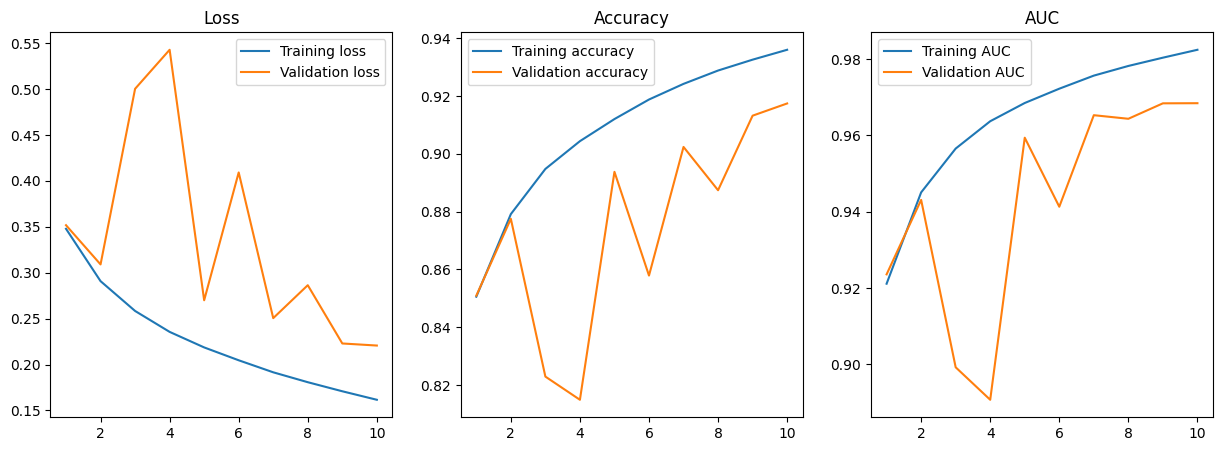

In [ ]:
f, ax = plt.subplots(1, 3, figsize = (15, 5))
ax[0].plot(range(1, 11), hist4.history['loss'], label = 'Training loss')
ax[0].plot(range(1, 11),hist4.history['val_loss'], label = 'Validation loss')
ax[0].legend()
ax[0].set_title('Loss')
ax[1].plot(range(1, 11),hist4.history['accuracy'], label = 'Training accuracy')
ax[1].plot(range(1, 11),hist4.history['val_accuracy'], label = 'Validation accuracy')
ax[1].legend()
ax[1].set_title('Accuracy')
ax[2].plot(range(1, 11),hist4.history['auc_1'], label = 'Training AUC')
ax[2].plot(range(1, 11),hist4.history['val_auc_1'], label = 'Validation AUC')
ax[2].legend()
ax[2].set_title('AUC')

The above loss plot illustrates that the new CNN has a smooth learning process and it's not suffered from underfitting or overfitting anymore. Considering canerous tumoer only exists in the middle region, shifting images may harm the learning process. It further proves that image augmentation need to be carefully applied depending on the data. Besides, dropout technique also seems to have some effect of underfitting. Overall, this CNN has the best performance and its architecture will be inherited for hyperparameter tuning. In the next step, a hyperparamter tuning will be implemented to select the best model with optimized learning rate.

In [13]:
# hyperparameter tuning
def build_model(hp):
    model = Sequential()
    model.add(Conv2D(16, (3,3), 1, activation = 'relu', input_shape = (96, 96, 3)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.2))

    model.add(Conv2D(32, (5,5), 1, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (3,3), 1, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.2))

    model.add(Flatten())

    model.add(Dense(96, activation = 'relu'))
    model.add(Dense(64, activation = 'relu'))
    model.add(Dense(1, activation = 'sigmoid'))

    learning_rate = hp.Float('lr', min_value = 1e-5, max_value = 1e-3, sampling = 'log')
    adam = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    model.compile(optimizer = adam, loss = tf.losses.BinaryCrossentropy(), metrics = ['accuracy', tf.keras.metrics.AUC(name = 'auc')])

    return model

rs_tuner = keras_tuner.RandomSearch(
    hypermodel = build_model,
    objective = keras_tuner.Objective('val_auc', direction='max'),
    max_trials = 3,
    executions_per_trial = 2,
    overwrite = True,
    directory = local_path,
    project_name = 'hp_tune'
)

rs_tuner.search_space_summary()

Search space summary
Default search space size: 1
lr (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.001, 'step': None, 'sampling': 'log'}


In [14]:
# hyperparameter tuning
rs_tuner.search(train_generator2, epochs = 10, validation_data = val_generator2)

Trial 3 Complete [00h 57m 02s]
val_auc: 0.954166829586029

Best val_auc So Far: 0.9686267971992493
Total elapsed time: 02h 49m 29s


In [15]:
# hyperparameter tuning summary
hp_summary = []
for i in range(3):
    hp_dict = rs_tuner.get_best_hyperparameters(10)[i].values
    hp_dict['loss'] = round(float(str(rs_tuner.oracle.trials[str(i)].metrics.get_history('loss'))[26:33]), 44)
    hp_dict['auc'] = round(float(str(rs_tuner.oracle.trials[str(i)].metrics.get_history('auc'))[26:33]), 44)
    hp_dict['val_loss'] = round(float(str(rs_tuner.oracle.trials[str(i)].metrics.get_history('val_loss'))[26:33]), 44)
    hp_dict['val_auc'] = round(float(str(rs_tuner.oracle.trials[str(i)].metrics.get_history('val_auc'))[26:33]), 44)
    hp_summary.append(hp_dict)
hp_summary_df = pd.DataFrame.from_dict(hp_summary, orient = 'columns')
hp_summary_df.rename(columns = {'units':'Units', 'lr':'Learning Rate', 'loss':'Training Loss', 'auc':'Training AUC', 'val_loss':'Validation Loss', 'val_auc':'Validation AUC'})
hp_summary_df

,lr,loss,auc,val_loss,val_auc
0,0.000592,0.18664,0.97668,0.22349,0.96855
1,0.000493,0.19323,0.97518,0.22406,0.96862
2,0.000106,0.22416,0.96698,0.28184,0.95416


The optimized model was achieved with a learning rate around 0.0005. The validation AUC score is 0.96862 which is slightly lower than the training AUC score and greater than the AUC score of all models trained earlier. Thus, this model will be selected as the final model. In the next step, test images will be classified with the final model. The prediction will be submitted to the Kaggle competition for performance evaluation.

In [16]:
# image filenames
im_name = []
for im in os.listdir(os.path.join(local_path, 'test_data')):
  im_name.append(im)

pred_df = pd.DataFrame(im_name, columns = ['im_name'])
pred_df.head()

,im_name
0,96f68f48e304513700c4efc18bea36248e85cae4.tif
1,fc252da0c98df900a120bcadd8451d5f21695029.tif
2,3df9fbe719033870e6b5f55d1bf579fa5f5b55b5.tif
3,b0861b83472e26ad5989b6e89a96fbf090232b13.tif
4,80914d4fbad4c510c1fa067955663706e6f78b33.tif


In [17]:
# import test images
test_datagen = image.ImageDataGenerator(
    rescale = 1./255
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe = pred_df,
    directory = os.path.join(local_path, 'test_data'),
    x_col = 'im_name',
    y_col = None,
    class_mode = None,
    target_size = (96, 96),
    batch_size = 32,
    shuffle = False,
)

Found 57458 validated image filenames.


In [18]:
# prediction
pred_df['id'] = pred_df['im_name'].str.replace('.tif', '')
pred_df = pred_df.drop(['im_name'], axis = 1)

model_opt = rs_tuner.get_best_models(num_models = 1)[0]
cnn_pred = model_opt.predict(test_generator)
pred_array = (cnn_pred >= 0.5).astype(int)
pred_df['label'] = pred_array
pred_df.to_csv(os.path.join(local_path, 'cnn_pred.csv'), index = False)
pred_df.head()

1796/1796 [==============================] - 43s 24ms/step


,id,label
0,96f68f48e304513700c4efc18bea36248e85cae4,1
1,fc252da0c98df900a120bcadd8451d5f21695029,1
2,3df9fbe719033870e6b5f55d1bf579fa5f5b55b5,1
3,b0861b83472e26ad5989b6e89a96fbf090232b13,0
4,80914d4fbad4c510c1fa067955663706e6f78b33,1


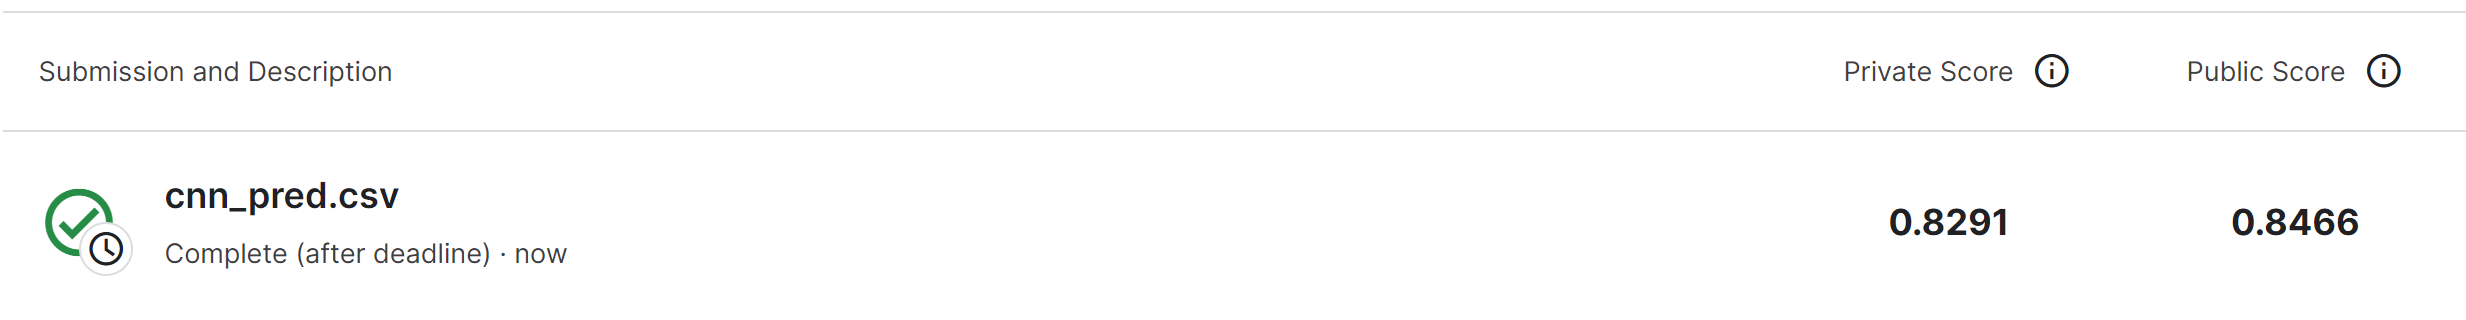

Our model has a private score and public score around 0.8. Considering the model complexity, the performance score is decent and acceptable.

## Discussion

In this case study, a CNN is developed through a performance-based iterative process. Learning rate is tuned to improve the performance and the effect of image augmentation, batch normalization and dropout layer are studied as well. During the examination of performance plot, it's recommended to compare validation loss with the training loss of half epoch earlier to gain clearer evidence of overfitting or underfitting issue. Another important takeaway is that a larger filter size contributes to a higher accuracy score. In addition, batch normalization and dropout technique also have some effects to handle underfitting problem even though they are mostly applied to address overfitting issue. Lastly, image augmentation should be carefully used since some transformation is not suitable for certain data. There are also opportunities to further improve the neural network. A wider range of hyperparameters can be tuned with random search technique to improve the performance if enough resources (GPU, etc.) are available. Also, a pre-trained network that is proven to be efficient and have a good performance on medical images can be inherited and fine-tunned with using our data.